In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

Epoch 1/50
164/164 [==============================] - 2s 8ms/step - loss: 0.0500 - val_loss: 0.0147
Epoch 2/50
164/164 [==============================] - 1s 6ms/step - loss: 0.0118 - val_loss: 0.0142
Epoch 3/50
164/164 [==============================] - 1s 7ms/step - loss: 0.0113 - val_loss: 0.0134
Epoch 4/50
164/164 [==============================] - 1s 6ms/step - loss: 0.0111 - val_loss: 0.0133
Epoch 5/50
164/164 [==============================] - 1s 6ms/step - loss: 0.0109 - val_loss: 0.0126
Epoch 6/50
164/164 [==============================] - 1s 6ms/step - loss: 0.0107 - val_loss: 0.0123
Epoch 7/50
164/164 [==============================] - 1s 6ms/step - loss: 0.0104 - val_loss: 0.0124
Epoch 8/50
164/164 [==============================] - 1s 6ms/step - loss: 0.0102 - val_loss: 0.0120
Epoch 9/50
164/164 [==============================] - 1s 6ms/step - loss: 0.0100 - val_loss: 0.0115
Epoch 10/50
164/164 [==============================] - 1s 6ms/step - loss: 0.0099 - val_loss: 0.0114

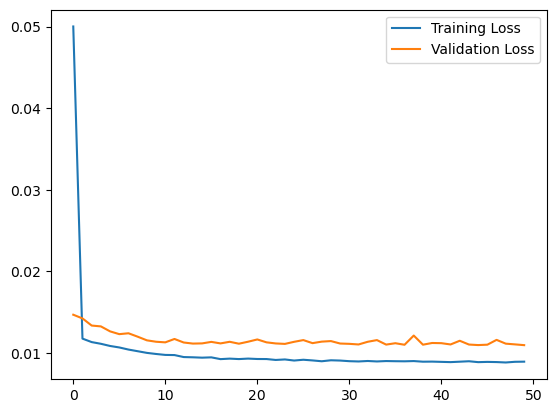

46/46 [==============================] - 0s 2ms/step


In [43]:
# CSV 파일 경로 지정
file_path = 'AAOS.csv'

# CSV 파일 읽기
df = pd.read_csv(file_path, encoding='cp949')

# data.iloc[:, 2:] = data.iloc[:, 2:].apply(lambda col: col.fillna(col.mean()))
# data = data['1.5M 평균 기온(°C)']  # 'predicted_temp_column_name'에는 실제 온도 데이터가 있는 
# data['일시'] = pd.to_datetime(data['일시'])

# '일시' 열을 인덱스로 설정
# data.set_index('일시', inplace=True)

# features = ['1.5M 평균 기온(°C)']
# df = data['1.5M 평균 기온(°C)']

df.iloc[:, 12:] = df.iloc[:, 12:].apply(lambda col: col.fillna(col.mean()))
df.iloc[:, 3:] = df.iloc[:, 3:].apply(lambda col: col.fillna(col.mean()))

# '일시' 열을 Datetime 형식으로 변환
df['일시'] = pd.to_datetime(df['일시'])

# '일시' 열을 인덱스로 설정
df.set_index('일시', inplace=True)

# 필요한 특성 선택
features = ['1.5M 평균 기온(°C)','1.5M 평균 습도(%)']
df = df[features]


# 데이터 스케일링 (0과 1 사이로 정규화)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# 시계열 데이터를 학습 데이터로 변환
X, y = [], []

# 예측 기간 설정 (예: 마지막 30일을 통해 다음 날을 예측)
lookback = 30

for i in range(len(df_scaled) - lookback):
    X.append(df_scaled[i:(i + lookback)])
    y.append(df_scaled[i + lookback])

X, y = np.array(X), np.array(y)

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2))  # 출력 노드 수는 특성의 수와 동일하게 설정
model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Training 및 Validation Loss 그래프로 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# 테스트 데이터를 사용하여 예측
y_pred = model.predict(X_test)


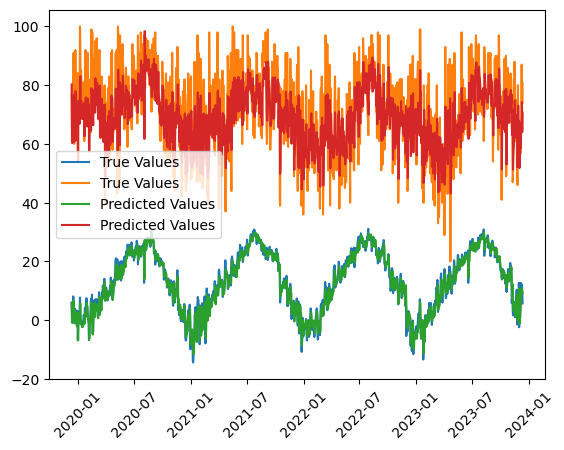

1/1 [==============================] - 0s 16ms/step
Predicted Weather for the next 7 days:
Predicted Temperature :  4.986814
Predicted Humidity :  63.531864
Root Mean Squared Error (RMSE) for 1.5M 평균 기온(°C): 2.4291257596754217
R Squared (R^2) for 1.5M 평균 기온(°C): 0.9435590599738563
Root Mean Squared Error (RMSE) for 1.5M 평균 습도(%): 10.584426175992892
R Squared (R^2) for 1.5M 평균 습도(%): 0.37071307421722066


In [44]:

# 예측 결과 시각화
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test), label='True Values')
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_pred), label='Predicted Values')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Predict test data의 마지막 7개 데이터 출력
last_7_days = df_scaled[-lookback:]
last_7_days = last_7_days.reshape((1, lookback, len(features)))
next_day_prediction = model.predict(last_7_days)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
predicted_temp = next_day_prediction[0, 0]
predicted_humi = next_day_prediction[0, 1]
print("Predicted Weather for the next 7 days:")
print("Predicted Temperature : ", predicted_temp)
print("Predicted Humidity : ", predicted_humi)

# # Calculate RMSE
# rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred)))
# print(f'Root Mean Squared Error (RMSE): {rmse}')


# # Calculate R squared
# r2 = r2_score(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))
# print(f'R Squared (R^2): {r2}')

for i in range(len(features)):
    # Calculate RMSE for each feature
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test)[:, i], scaler.inverse_transform(y_pred)[:, i]))
    print(f'Root Mean Squared Error (RMSE) for {features[i]}: {rmse}')

    # Calculate R squared for each feature
    r2 = r2_score(scaler.inverse_transform(y_test)[:, i], scaler.inverse_transform(y_pred)[:, i])
    print(f'R Squared (R^2) for {features[i]}: {r2}')

In [33]:
# predicted_temp = 25
# predicted_humi = 30

def detect_plant_disease(predicted_temp, predicted_humi):
    if predicted_temp >= 20:
        if predicted_temp >= 25 and predicted_temp <= 30 and predicted_humi >= 80 and predicted_humi <= 90:
            return "잎마름병이 극심합니다. 주의하세요"
        elif predicted_temp >= 20 and predicted_temp < 25 and predicted_humi >= 90:
            return "잎곰팡이병에 주의하세요"
        elif predicted_temp >= 25 and predicted_temp <= 28 and predicted_humi <= 55:
            return "흰가루병에 주의하세요"
        else:
            return "건강한 상태"
    else:
        return "건강한 상태"
    
disease_detect_result = detect_plant_disease(predicted_temp, predicted_humi)
print(disease_detect_result)

건강한 상태
